In [30]:
import sys

from tqdm import tqdm
import numpy as np
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

sys.path.append("../")
from src.graph_preprocessing import load_graph_data

In [4]:
sub_graph, residual_g, train_samples, train_labels, test_samples, test_labels = load_graph_data("../experiments/0.4_0.8")

# Graph based features

In [38]:
def graph_feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = [] 
    
    deg_centrality = nx.degree_centrality(graph)
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality  
        # diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        aai = list(nx.adamic_adar_index(graph, [edge]))[0][-1]

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [edge]))[0][-1]
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        pref_attach, aai, jacard_coeff])) 
        
    return np.array(feature_vector)

# Meta-information based

# Textual information based

# Merging all

In [43]:
def feature_extractor(graph, samples, features_method=[graph_feature_extractor]):
    feature_vectors = []
    for feature in features_method:
        feature_vectors.append(feature(graph, samples))
    feature_vector = np.concatenate(feature_vectors, axis=1)
    return feature_vector

In [44]:
train_features = feature_extractor(sub_graph, train_samples)
test_features = feature_extractor(sub_graph, test_samples)

100%|██████████| 21242/21242 [00:00<00:00, 21409.72it/s]


# Classification

In [33]:
def prediction(train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    
    lr = LogisticRegression()
    lr.fit(train_features, train_labels)
    
    train_preds = lr.predict_proba(train_features)[:, 1]
    test_preds = lr.predict_proba(test_features)[:, 1]
    
    print(test_preds)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = roc_auc_score(test_labels, test_preds)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return lr, roc_auc

[0.13084534 0.99774169 1.         ... 0.12881983 0.13365086 0.13843966]


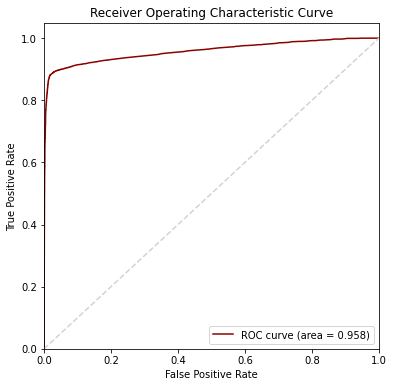

In [34]:
lr, roc_auc = prediction(train_features, test_features, train_labels, test_labels)

In [35]:
test_preds = lr.predict(test_features)
f1_score(test_labels, test_preds)

0.9281724257254436